# Example of simulating (and detecting) Neanderthal introgression

This command will simulate 3% Neanderthal introgression into Europeans at 55 ky, lasting 25 years (i.e. one generation pulse of introgression), simulating 250 Mb sequence in total. It will sample individuals on the European lineage at given time points (oldest at 45 ky, youngest in the present), and at the end, calculate some admixture statistics, and infer Neanderthal introgressed haplotypes for each sampled individual, and dump a table with all simulated SNPs.

All output files will be generated with a common shared prefix:

* Admixture statistics are written in a table `{output_prefix}_stats.tsv`.
* Introgressed haplotypes are written (for each individual) in separate files `{output_prefix}_{name}_{source_pop}_haplotypes.tsv`.
* Table of all SNPs for all populations will be written to `{output_prefix}_snps.tsv` in a tabular format.

```
mkdir tmp
./demography.py \
    --neand 55000,25,0,0.03 \
    --eur-ages `seq -s" " 45000 -2500 0` \
    --seq-len 250_000_000 \
    --stats true_neand \
    --introgression neand-eur \
    --snps \
    --output-prefix tmp/example
```

(Note, that split times between populations are currently fixed.)

There are several additional, mostly self-explanatory, options. For example, `--eurA` or `--eurB` will simulate gene flow between European lineage and two possible African populations (representing Yoruba and Dinka).

```
./demography.py --help
usage: demography.py [-h] [--eurA start,duration,rate1,rate2]
                     [--eurB start,duration,rate1,rate2]
                     [--afr start,duration,rate1,rate2]
                     [--neand start,duration,rate1,rate2]
                     [--Ne-nonafr NE_NONAFR] [--Ne-afr NE_AFR] --seq-len
                     SEQ_LEN
                     (--eur-ages EUR_AGES [EUR_AGES ...] | --neur NEUR)
                     [--nasn NASN] [--nafrA NAFRA] [--nafrB NAFRB]
                     [--introgression from-to] [--snps]
                     [--stats {true_neand,asc_neand,indirect,direct,afr_f4} [{true_neand,asc_neand,indirect,direct,afr_f4} ...]]
                     [--output-prefix FILE] [--debug]

optional arguments:
  -h, --help            show this help message and exit
  --eurA start,duration,rate1,rate2
                        EUR <-> AFR_A geneflow
  --eurB start,duration,rate1,rate2
                        EUR <-> AFR_B geneflow
  --afr start,duration,rate1,rate2
                        AFR_A <-> AFR_B geneflow
  --neand start,duration,rate1,rate2
                        nonAfr <-> Neanderthal geneflow
  --Ne-nonafr NE_NONAFR
  --Ne-afr NE_AFR
  --seq-len SEQ_LEN     Sequence length
  --eur-ages EUR_AGES [EUR_AGES ...]
                        Ages of European samples [years BP]
  --neur NEUR           Number of European chromosomes to simulate
  --nasn NASN           Number of Asian chromosomes to simulate
  --nafrA NAFRA         Number of AfrB chromosomes to simulate
  --nafrB NAFRB         Number of AfrA chromosomes to simulate
  --introgression from-to
                        Pair of populations for introgression detection
  --snps                Save all SNPs to a file
  --stats {true_neand,asc_neand,indirect,direct,afr_f4} [{true_neand,asc_neand,indirect,direct,afr_f4} ...]
                        Which statistics to calculate?
  --output-prefix FILE  Prefix of output files
  --debug               Debug info
  ```

In [1]:
library(tidyverse)

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.1.0     ✔ purrr   0.2.5
✔ tibble  2.0.1     ✔ dplyr   0.7.8
✔ tidyr   0.8.2     ✔ stringr 1.3.1
✔ readr   1.3.1     ✔ forcats 0.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


In [2]:
haplotypes <-
    list.files("tmp/", "*neand_haplotypes*") %>%
    seq_along %>%
    {. - 1} %>%
    map_dfr(~ read_tsv(paste0("tmp/example_eur", .x, "_neand_haplotypes.tsv"), col_types = "dd") %>%
                   mutate(len = end - start, name = paste0("eur", .x))) %>%
    mutate(name = factor(name, levels = paste0("eur", 0:length(unique(name))))) # order name factors by age

In [3]:
neand_props <- inner_join(
    read_tsv("tmp/example_stats.tsv"),
    group_by(haplotypes, name) %>% summarise(hap_neand = sum(len) / 250e6)
)

Parsed with column specification:
cols(
  name = col_character(),
  age = col_double(),
  true_neand = col_double()
)
Joining, by = "name"
Warning message:
“Column `name` joining character vector and factor, coercing into character vector”

## Sanity check

### Correlation of total introgressed haplotype length with proportion of alleles matching the Neanderthal state

Both of these represent the true Neanderthal ancestry (taken directly from the simulation, without any ascertainment), so should correlate perfectly.

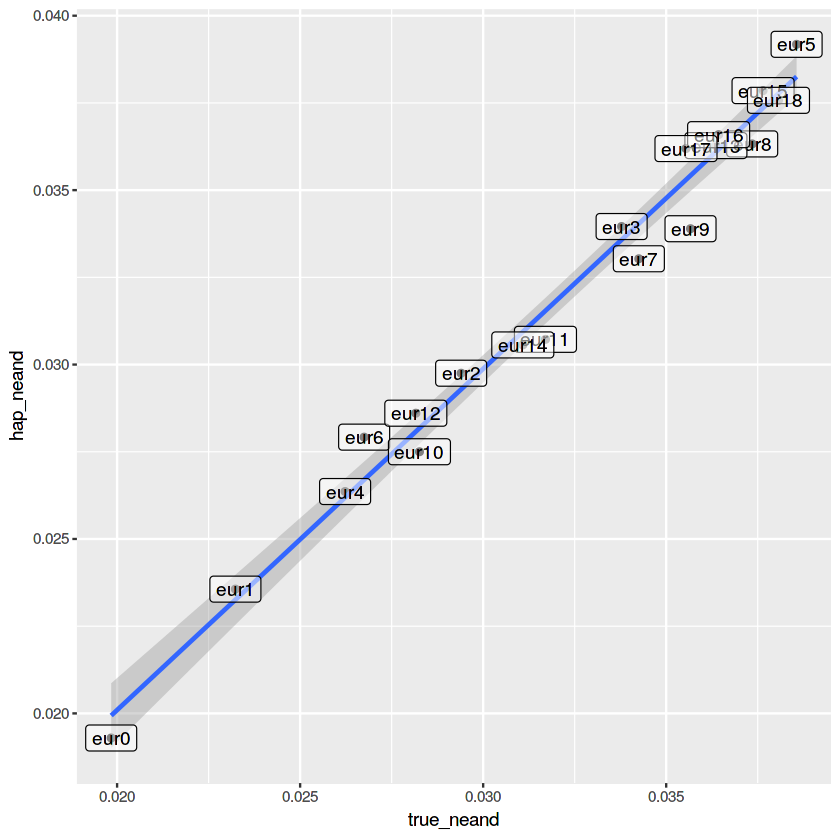

In [4]:
ggplot(neand_props, aes(true_neand, hap_neand, label = name)) +
    geom_point() +
    geom_smooth(method="lm") +
    geom_label(alpha = 1/2)

In [5]:
haplotypes %>% head

start,end,len,name
0,41471.74,41471.74,eur0
31531883,31659596.78,127713.78,eur0
35739172,36137958.47,398786.86,eur0
49381192,49442829.87,61638.36,eur0
56426822,56722552.30,295730.72,eur0
74114754,74340117.41,225363.47,eur0


## What is the spatial distribution of introgressed haplotypes?

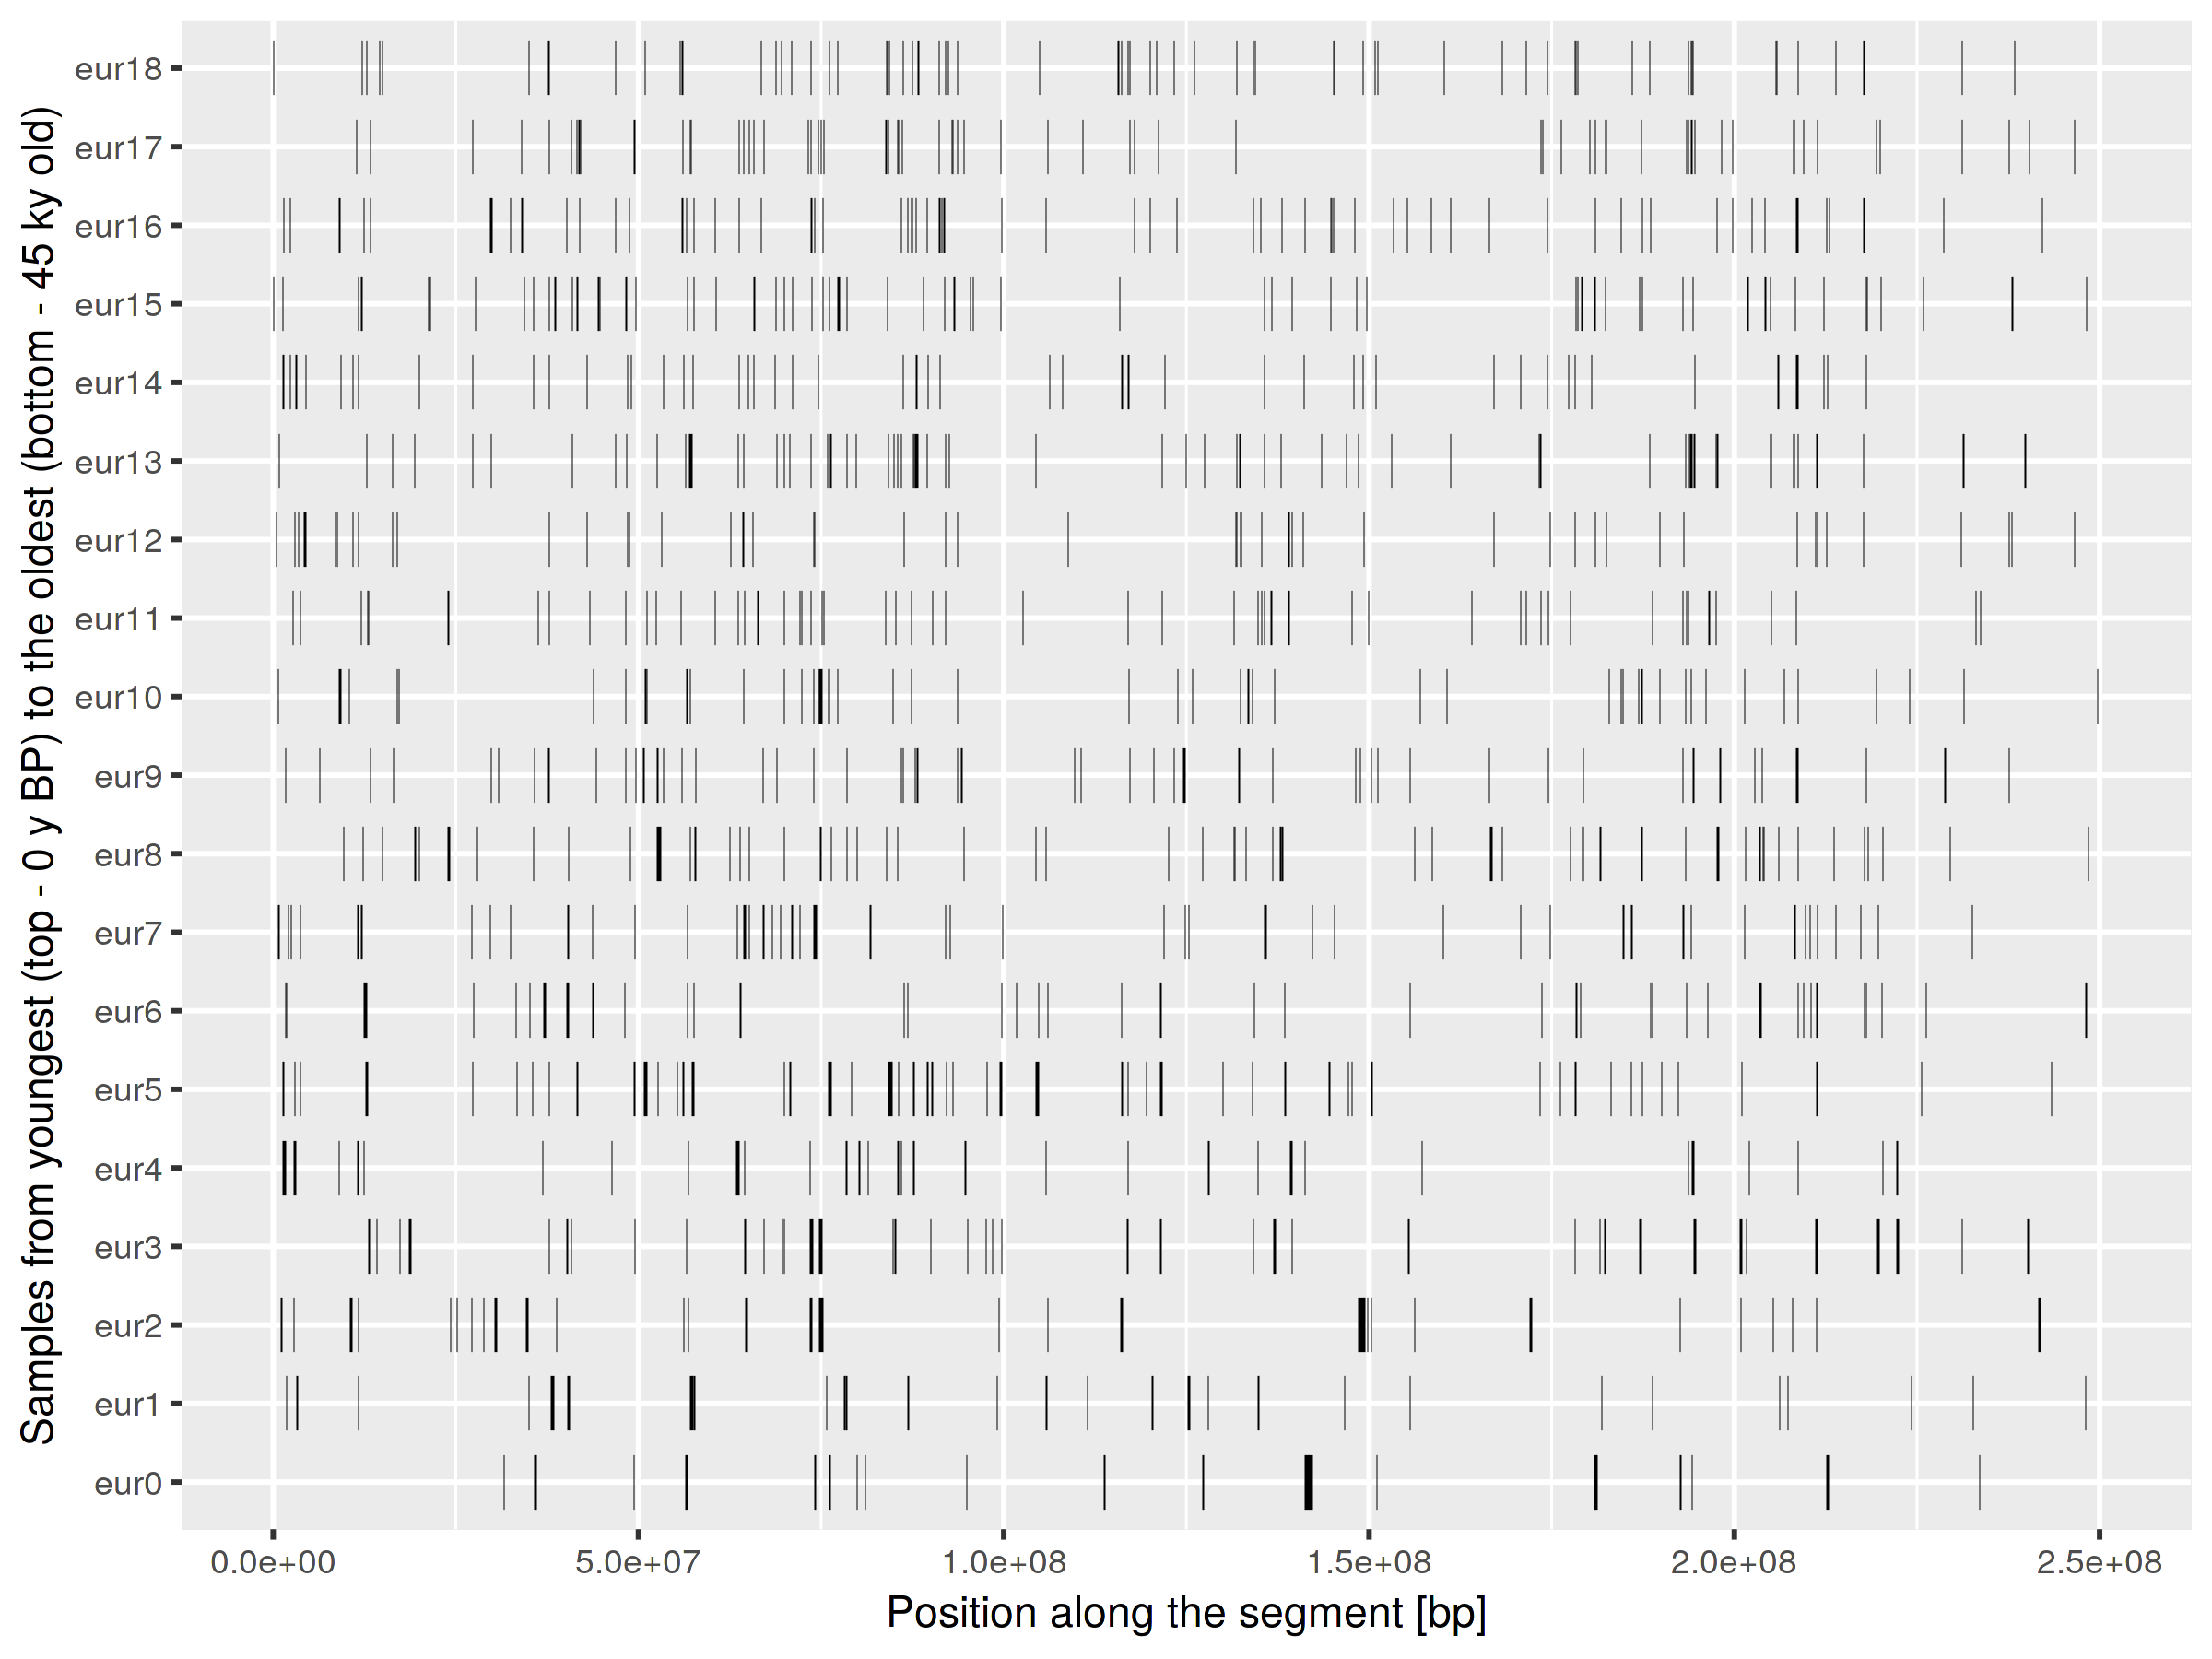

In [9]:
options(repr.plot.width = 8, repr.plot.height = 6, repr.plot.res = 300)

haplotypes %>%
ggplot() +
    geom_segment(aes(x = start, y = name, xend = end, yend = name), size = 5, lineend = "butt") +
    xlab("Position along the segment [bp]") +
    ylab("Samples from youngest (top - 0 y BP) to the oldest (bottom - 45 ky old)")

## What are the introgressed fragments lengths w.r.t. age of each simulated sample?

Here "eur0" is the oldest sample (45ky old) and increasing numbers belong to samples in 2,500 years increments.

We expect to see increasingly long blocks in oldest samples.

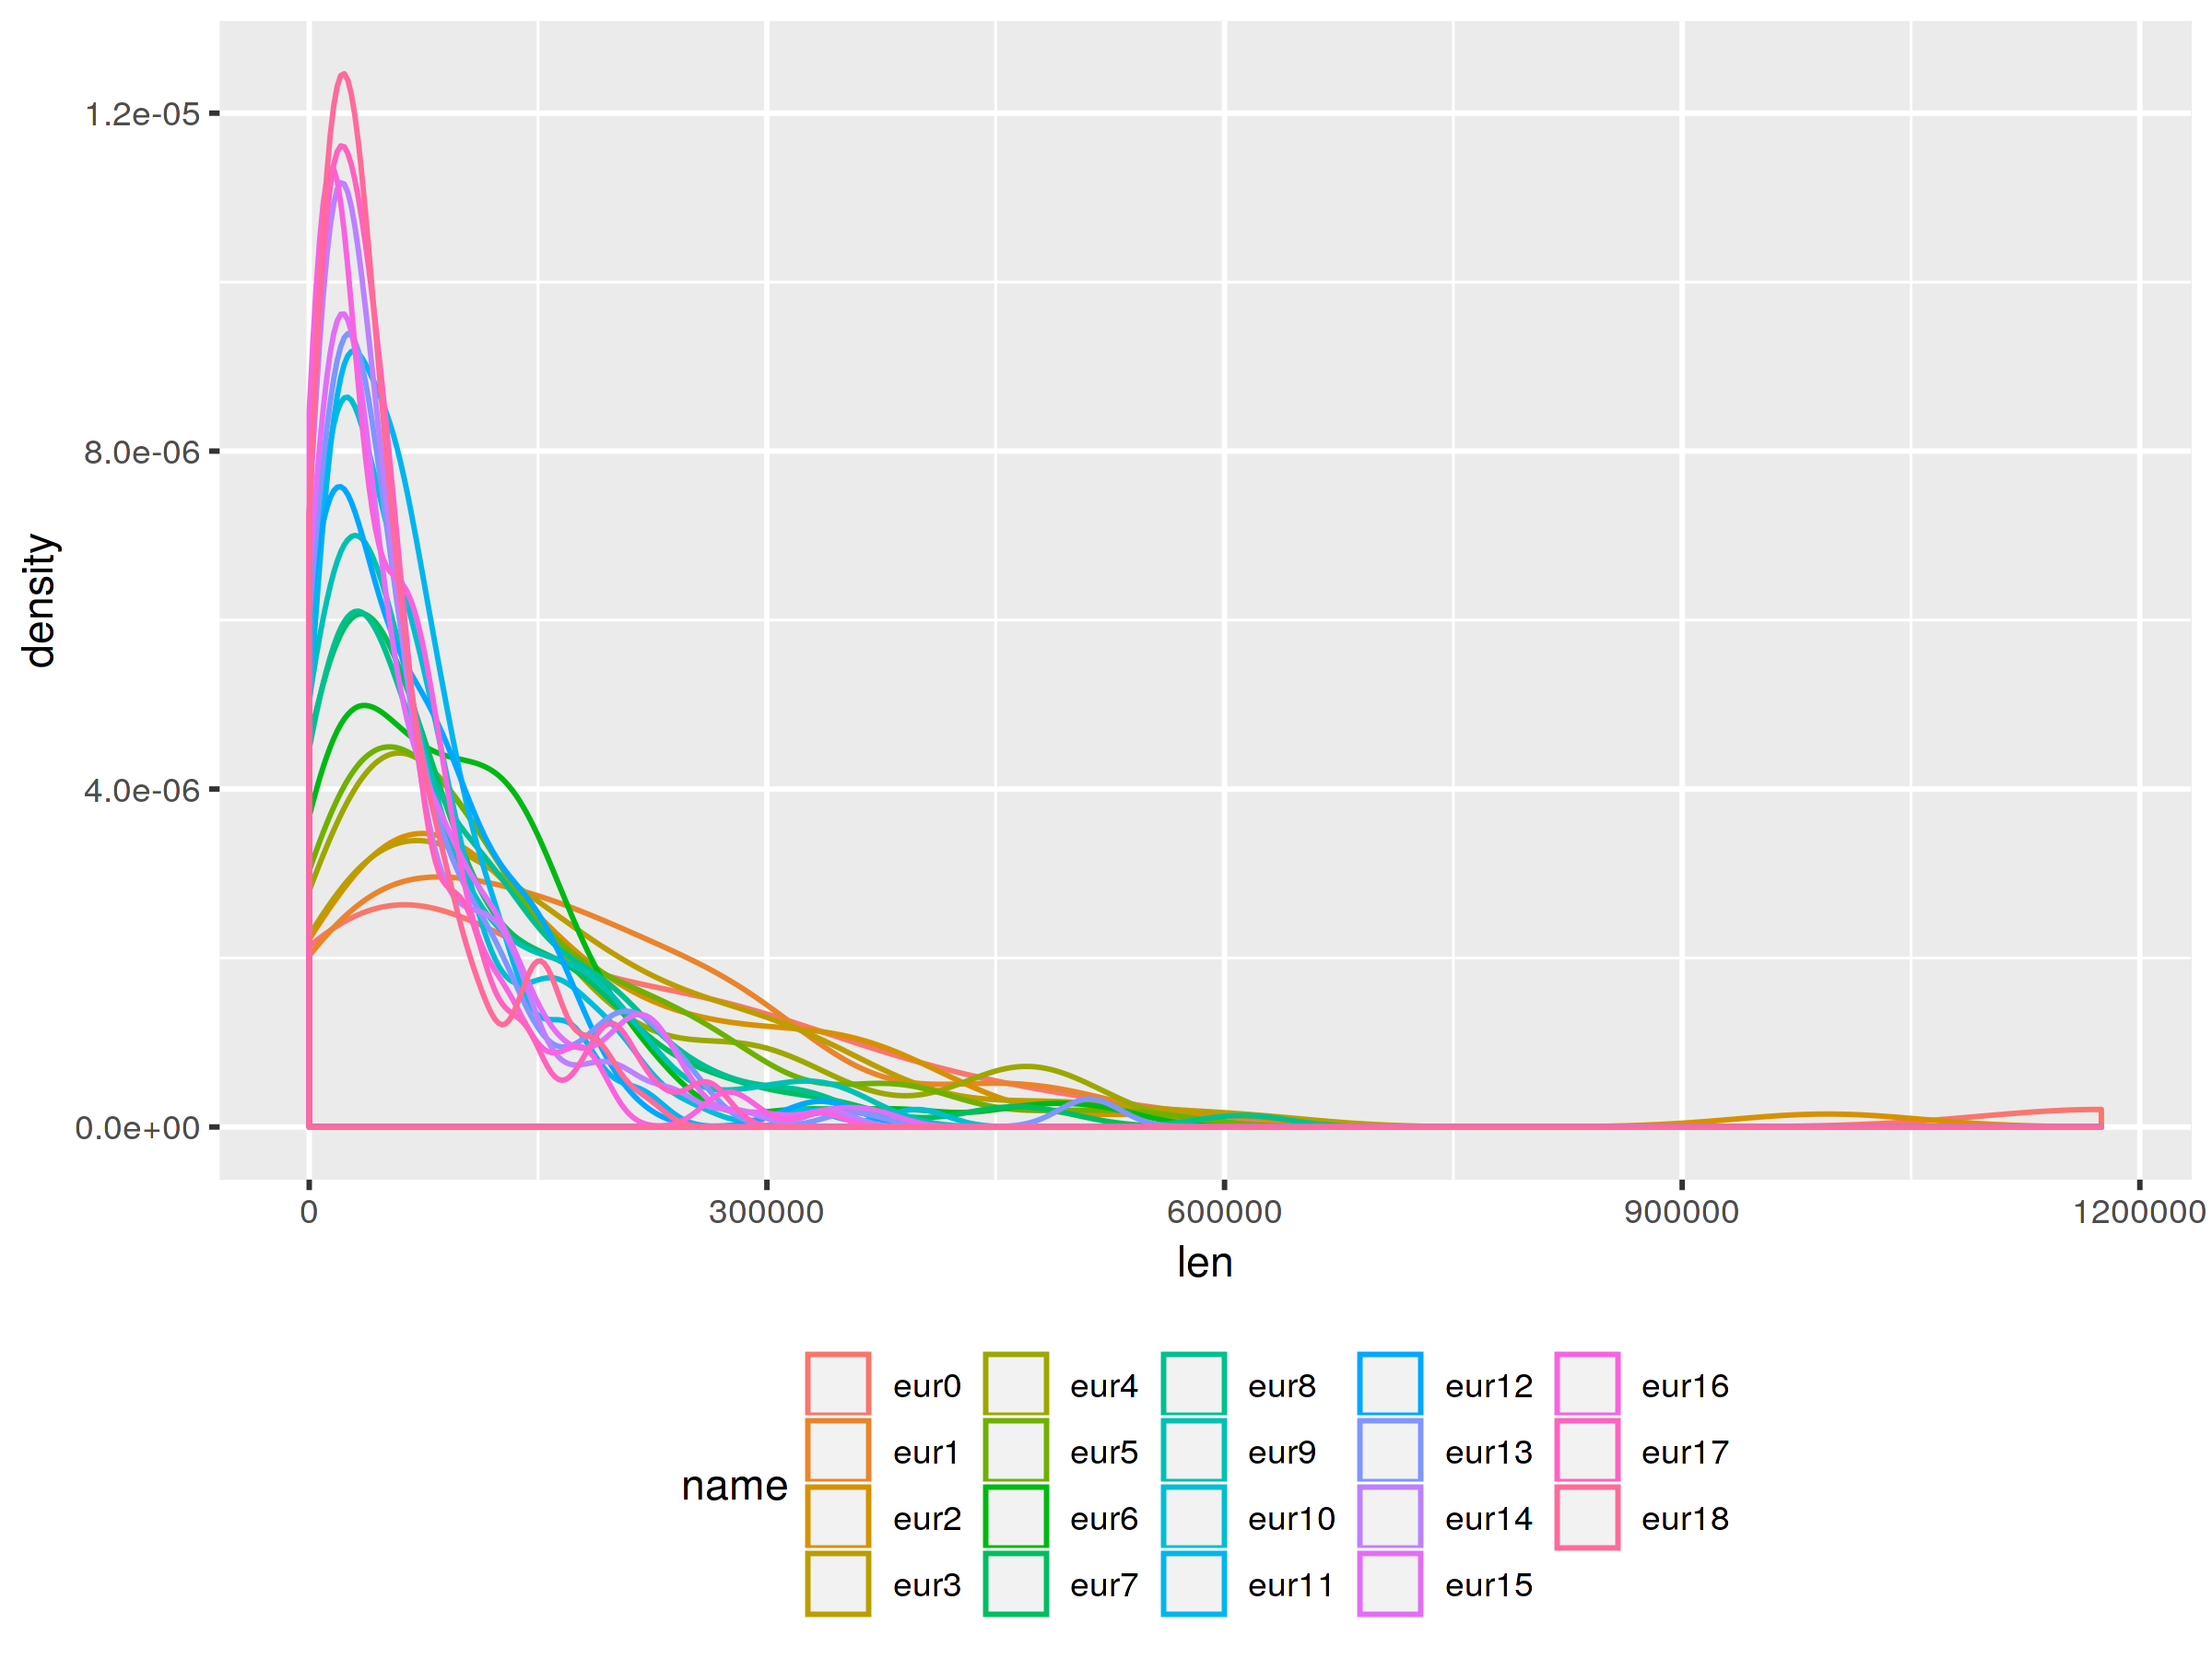

In [7]:
options(repr.plot.width = 8, repr.plot.height = 6, repr.plot.res = 300)

haplotypes %>%
ggplot(aes(len, color = name)) +
    geom_density() +
    theme(legend.position = "bottom")